# Team Members:

- Brian Gaither
- Sabrina Purvis
- Andrew Larsen
- Aurian Ghaemmaghami

# Overview

This notebook is organized in sections by Model.  There are two tasks. Task 1 is regression and Task 2 is Classification.  There are three models per task.

For each Model in each Task, we will walk the reader through the various phases of this deliverable: Data Preparation,  Modeling and Evaluation

<a id="top"></a>
## Contents
* **<a href="#task1">Task 1 - Regression</a>**
    - <a href="#task1Model1">Model 1 - KNN</a>
    - <a href="#task1Model2">Model 2 - Logistic Regression</a>
    - <a href="#task1Model3">Model 3 - Random Forest Regression</a>
    - <a href="#task1Compare">Task 1 - Comparing the Three Models</a>
    - <a href="#task1Attributes">Task 1 - Important Attributes</a>
    - <a href="#task1Deployment">Task 1 - Deployment</a>
* **<a href="#task2">Task 2 - Classification</a>**
    - <a href="#task2Model1">Model 1 - Random Forest (Approach 1)</a>
    - <a href="#task2Model2">Model 2 - Logistic Regression</a>
    - <a href="#task2Model3">Model 3 - Random Forest (Approach 2)</a>
    - <a href="#task2Compare">Task 2 - Comparing the Three Models</a>
    - <a href="#task2Attributes">Task 2 - Important Attributes</a>
    - <a href="#task2Deployment">Task 2 - Deployment</a>
* **<a href="#Exceptional">Exceptional Work</a>**


<a href="#top">Back to Top</a>
<a id="task1"></a>
# Task 1 - Regression

The regression task is aiming to predict the volume of crime on a given day, for a given time period of the day (Early Morning, Morning, Day, Afternoon, etc...) by location.

<a href="#top">Back to Top</a>
<a id="task1Model1"></a>
## Task 1 - Regression - Model 1 - KNN

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task1Model2"></a>
## Task 1 - Regression - Model 2 - Logistic Regression

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task1Model3"></a>
## Task 1 - Regression - Model 3 - Random Forest Regression

**Goal:**  
We want to develop a model that will predict crime volume for different NYC Borough locations for different times of day around the year.  Therefore, we've implemented a regression model using Random Forest Regression. 

This model can be used to get an accurate idea of the volume of crime to expect and could be useful for law enforcement to know how to distribute man power throughout the city for maximum coverage on give days and times of day.

### Data Preparation Part 1

For initial model development and feature analysis, the features were reduced down to a subset that sought to avoid data leakage and maximize liklihood of importance based on whether or not the value changed daily.  We dropped features such as population, income and home sales prices as they were annual figures so didn't change on a daily basis, thus do not have discriminatory power.  

Preprocessing of the data consisted of aggregating the raw data creating the count_cmplnt field that will be used as our target variable.  The count_cmplnt field is the total volume of crimes that occurred during a given period of the day (Early Morning, Morning, Day, Afternoon, etc..)  

For this model, we dropped variables that have very little to no predictive power or were captured by other variables. These included, population, PC_Income, Hm_Sls_Price_Range and cmplnt_fr_dt as that is captured by month, day, and year.

We chose to one hot encode the categorical features and scale the continuous variables.

One Hot encoded features:
- Daytime
- Day_Name
- Month
- Season
- BORO_NM
- Holiday
- Event

Scaled features:
- PRCP
- SNOW
- TMIN
- TMAX

Features left unchanged:
- is_Holiday
- is_Event
- Day
- Year
- GeoCell

These features were used for initial model development.  In Data Preparation Part 2, we detail which are the final features selected based in Gini-Importance along with their meaning.

In [3]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab 2\\Data\\Training_and_Test_Set.csv"
#load Data into Pandas
df_Crime = pd.read_csv(file_path)

In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_c

In [4]:
df_Crime.head(5)

,CMPLNT_FR_DT,Daytime,Day_Name,Month,Day,Year,Season,GeoCell,BORO_NM,PRCP,...,TMIN,TMAX,Population,PC_INCOME,Hm_Sls_Price_Range,Holiday,Event,is_Holiday,is_Event,count_cmplnt
0,11/26/2014,Morning,Wednesday,November,26.0,2014.0,Fall,66.0,QUEENS,1.24,...,34,51,"2,250,002",40997,Medium,NaN,NaN,0,0,1
1,12/1/2014,Late Night,Monday,December,1.0,2014.0,Winter,60.0,QUEENS,0.09,...,42,65,"2,250,002",40997,Medium,NaN,NaN,0,0,1
2,11/10/2015,Morning,Tuesday,November,10.0,2015.0,Fall,15.0,BROOKLYN,0.26,...,51,57,"2,552,911",43915,High,NaN,NaN,0,0,2
3,2/4/2014,Morning,Tuesday,February,4.0,2014.0,Winter,48.0,QUEENS,0.00,...,22,35,"2,250,002",40997,Medium,NaN,NaN,0,0,3
4,8/25/2015,Late Night,Tuesday,August,25.0,2015.0,Summer,35.0,BROOKLYN,0.00,...,73,90,"2,552,911",43915,High,NaN,NaN,0,0,1


In [5]:
df_Crime.shape

(170650, 21)

In [6]:
#let's check for NaN values in the dataset
len(df_Crime) - df_Crime.count()

CMPLNT_FR_DT               0
Daytime                    0
Day_Name                   0
Month                      0
Day                        0
Year                       0
Season                     0
GeoCell                    0
BORO_NM                    0
PRCP                       0
SNOW                       0
TMIN                       0
TMAX                       0
Population                 0
PC_INCOME                  0
Hm_Sls_Price_Range         0
Holiday               166062
Event                 144780
is_Holiday                 0
is_Event                   0
count_cmplnt               0
dtype: int64

In [7]:
#since the only NANs are in Holiday and Event, we'll replace those NaNs with 'None'
df_Crime = df_Crime.fillna('None')

In [8]:
#let's make sure we've taken care of all the NaNs
len(df_Crime) - df_Crime.count()

CMPLNT_FR_DT          0
Daytime               0
Day_Name              0
Month                 0
Day                   0
Year                  0
Season                0
GeoCell               0
BORO_NM               0
PRCP                  0
SNOW                  0
TMIN                  0
TMAX                  0
Population            0
PC_INCOME             0
Hm_Sls_Price_Range    0
Holiday               0
Event                 0
is_Holiday            0
is_Event              0
count_cmplnt          0
dtype: int64

In [9]:
#drop population, PC_Income and Hm_Sls_Price_Range as they do not vary daily
#drop cmplnt_fr_dt as that is captured by month, day, and year
df_Crime = df_Crime[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event','count_cmplnt']]

In [10]:
X = df_Crime[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event']]
y = df_Crime[['count_cmplnt']]

### Data Preparation Part 2

After fitting a preliminary Random Forest Regression model, we've identified the top performing features using the Gini-importances with a threshold of >.004 which selects 22 features to feed into the model.

**Inputs to the model are:**

The following features are scaled:
- PRCP: amount of rainfall for the day
- TMIN: minimum temp for the day
- TMAX: maximum temp for the day

The following features are one hot encoded:
- Daytime:  time period of the day (Early Morning, Morning, Day, Afternoon, Evening, etc...)
- Month: the month for which you would like to predict crime volume
- Day_Name:  Day of the week (Monday, Tuesday, Wednesday, ect...)
- BORO_NM: Name of the borough you would like to predict crime volume

The following features are left unchanged:
- Day: the day of the month in numerical format
- Year: the year in numerical format YYYY
- GeoCell: We would need to perform feature transformation taking inputs x_coordinate and y_coordinate to calculate the GeoCell and then pass GeoCell value to the model.  This allows us to use geolocation details in a more abstract way to avoid overfitting to an exact location.

In [11]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season','BORO_NM','Holiday','Event']
columns_no_change = ['is_Holiday','is_Event','Day','Year','GeoCell','PRCP','SNOW','TMIN','TMAX']

df_existing = X[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(X[columns_to_encode])

#concatenate processed columns back together for X
X = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(X)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
X = df1

In [12]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#go ahead and split the data so we can scale data separately on training and then on test so we don't have leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

columns_to_scale = ['PRCP','SNOW','TMIN','TMAX']
#get a list of all columns without the columns to scale above
lstCols = X.columns.values.tolist()
lstCols.remove('PRCP')
lstCols.remove('SNOW')
lstCols.remove('TMIN')
lstCols.remove('TMAX')
columns_no_change = lstCols

df_existing = X_train[columns_no_change]
existing_cols = df_existing.to_numpy()

#scaler
scaler = StandardScaler()

#scale and encode separate columns
scaled_columns = scaler.fit_transform(X_train[columns_to_scale])

#concatenate processed columns back together for X_train
X_train_np = np.concatenate([scaled_columns,existing_cols],axis=1)

df_existing = X_test[columns_no_change]
existing_cols = df_existing.to_numpy()

#separately scale X_test
scaled_columns = scaler.transform(X_test[columns_to_scale]) #use the fit scaler object from X_train to scale X_test

X_test_np = np.concatenate([scaled_columns,existing_cols],axis=1)

In [13]:
#convert the numpy array back to a pandas dataframe for X_train
df1 = pd.DataFrame(X_train_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_train = df1

#convert the numpy array back to a pandas dataframe for X_test
df1 = pd.DataFrame(X_test_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_test = df1

In [14]:
#Let's take a look at the count_cmplnt target variable and get an idea of the distribution of crime volumes
#we can see that 75% of the data is between 1 and 6 crimes with some outliers of up to 132 crimes per period
y_train[['count_cmplnt']].describe()

,count_cmplnt
count,136520.000000
mean,4.711742
std,5.144352
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,132.000000


In [15]:
#let's perform a 5 fold cross validation using a baseline Random Forest Regression model and evaluate the results
#we can see that the five results are very close to one another so our model is quite stable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#create regressor object
reg = RandomForestRegressor(n_estimators = 50, random_state = 0)

#5 fold cross validation
%time cv_results = cross_val_score(reg, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print('Cross Validation Results: {}'.format(cv_results))

Wall time: 3min 53s
Cross Validation Results: [-1.65603575 -1.64081234 -1.63430779 -1.637207   -1.6277864 ]


In [16]:
#Next, we'll fit a base Random Forest Regression model again so that we can grab the most important features
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators = 50, random_state = 0)
%time reg.fit(X_train,y_train.values.ravel())
y_pred = reg.predict(X_test)

Wall time: 1min


### Modeling and Evaluation 1

To assess our regression models, we will be comparing the Root Mean Squared Error (RMSE) and Mean Absolute Error.  The best model will have the smallest resulting value from these metrics as it is indicative of the amount of error in our model.

RMSE is a measure of the goodness of fit of the model.  RMSE gives a penalty to large prediction errors by squaring it.
MAE is taking the sum of the absolute error.  MAE is a more direct representation of the sum of error terms.


<AxesSubplot:>

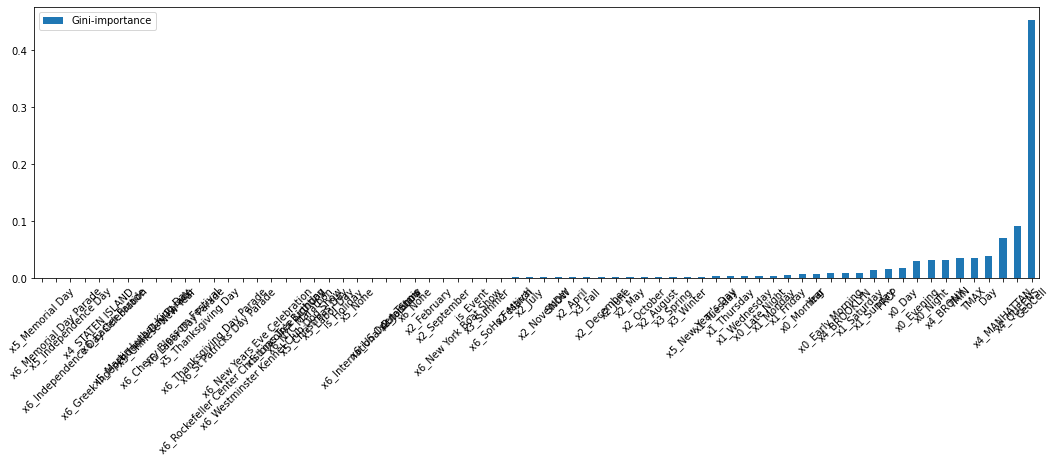

In [17]:
#get feature importance
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, reg.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    #print('{}, Score: %.5f'.format(feature) %(importance))

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(figsize=(18,5),kind='bar', rot=45)

In [18]:
#next, we'll grab the most important features using the threshold of gini-importance > .004
df_top_features = importances[importances['Gini-importance']>.004]
df_top_features['feature'] = df_top_features.index
top_features = df_top_features['feature'].tolist()

df_top_features.sort_values(by='Gini-importance',ascending=False)

C:\Users\BGaither\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Gini-importance,feature
GeoCell,0.453479,GeoCell
x4_QUEENS,0.092685,x4_QUEENS
x4_MANHATTAN,0.070824,x4_MANHATTAN
Day,0.039940,Day
TMAX,0.036671,TMAX
TMIN,0.035702,TMIN
x4_BRONX,0.033021,x4_BRONX
x0_Night,0.032610,x0_Night
x0_Evening,0.030263,x0_Evening
x0_Day,0.019059,x0_Day


In [19]:
#columns to keep based on feature importance
X_train=X_train[top_features]

X_test = X_test[top_features]

### Modeling and Evaluation 2

First off, we randomly selected 10% of the total dataset as a holdout set that we'll use to compare all models against for the regression task. This will ensure we're comparing models against the same dataset. 

Then, from the remaining 90% of the data, we split the data into an 80/20 training/test set.

This approach is appropriate as we want the model to learn how to predict crime volumes based on given independent variables.  The split was actually performed above in Data Perparation Part 2 of this section.

### Modeling and Evaluation 3

Now we will implement the Random Forest Regression model utilizing the data prepared above.

In [ ]:
#First, we'll perform a grid search to identify the optimal hyperparameters for the model
#Set up the parameters for grid search
parameters = {'n_estimators' : (30,50,70,90),
              'criterion' : ('mse','mae'),
              'max_depth' : (5,7,9,10),
              'max_features' : ('auto','sqrt'),
              'min_samples_split' : (2,4,6)
             }

In [ ]:
#since grid search is taking a long time with full training data, we'll subsample 
y_train.reset_index(drop=True,inplace=True)
df = pd.concat([X_train,y_train], axis=1)
len(df) - df.count()

In [ ]:
#take a randome 50% sample of the data for grid search
df_ds = df.sample(frac=.5,replace=True,random_state=1)
lstCols = df_ds.columns.values.tolist()
lstCols.remove('count_cmplnt')
X_ds_train = df_ds[lstCols]
y_ds_train = df_ds[['count_cmplnt']]

Since the grid search put a lot of load on my local machine, I used an AWS Sagemaker instance with an EC2 instance with a lot of compute to perform the Grid Search.  Therefore, the code to perform the grid search is below but I've included the results of the Grid Search in Markdown below to avoid running the code again locally.

In [ ]:
# reg_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1,oob_score=False),param_grid=parameters,cv=3,verbose=True)
# %time reg_grid_model = reg_grid.fit(X_ds_train,y_ds_train.values.ravel())

In [ ]:
# reg_grid_model.best_estimator_

#### Results of the Grid Search


Time taken:  4h 30min using SageMaker ml.c5.9xlarge

<b> Best Estimator: </b>

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
                      
                      
<b> Best Score (MAE)</b>

0.7295567982206977

#### Implement the Best Model from Grid Search

In [20]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(bootstrap=True, 
                            ccp_alpha=0.0, 
                            criterion='mae',
                            max_depth=10, 
                            max_features='auto', 
                            max_leaf_nodes=None,
                            max_samples=None, 
                            min_impurity_decrease=0.0,
                            min_impurity_split=None, 
                            min_samples_leaf=1,
                            min_samples_split=2, 
                            min_weight_fraction_leaf=0.0,
                            n_estimators=50, 
                            n_jobs=-1, 
                            oob_score=False,
                            random_state=None, 
                            verbose=0, 
                            warm_start=False)
%time reg.fit(X_train,y_train.values.ravel())

Wall time: 1h 1min 10s


RandomForestRegressor(criterion='mae', max_depth=10, n_estimators=50, n_jobs=-1)

In [21]:
y_pred = reg.predict(X_test)

### Modeling and Evaluation 4

#### Analyze the model against the Test Set

Analyzing the results of the final Random Forest Regression model.

Below, we can see the model metrics MAE, RMSE and the R<sup>2</sup> against the test set

In [22]:
from sklearn.metrics import *

#print out the mean absolute error (mae)
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred),'crimes per period')
print('Root Mean Squared Error:', mean_squared_error(y_test,y_pred, squared=False),'crimes per period')
print('r2:',r2_score(y_test,y_pred))

Mean Absolute Error: 1.7450969821271607 crimes per period
Root Mean Squared Error: 2.7592213367177587 crimes per period
r2: 0.7098933109052783


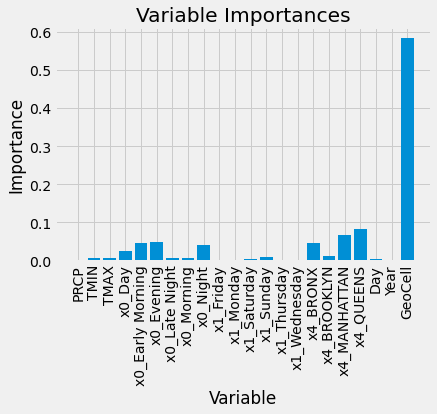

In [23]:
importances = list(reg.feature_importances_)
feature_list = X_train.columns.values.tolist()

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [24]:
#let's combine the data so that we can plot the predicted agains the actuals for a subset of the data to visually inspect
y_test.reset_index(drop=True,inplace=True)
df_testWithPreds = pd.concat([X_test,y_test],axis=1)
df_testWithPreds["prediction"] = reg.predict(X_test)
df_testWithPreds['PredLessActual'] = df_testWithPreds['prediction']-df_testWithPreds['count_cmplnt']

Text(0.5, 1.0, 'Actual and Predicted Values against Test Set')

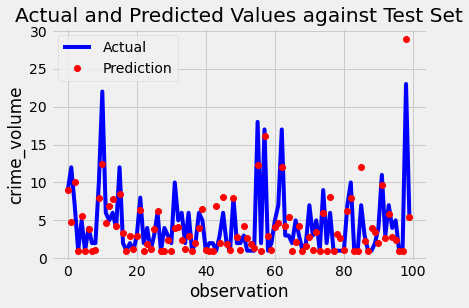

In [25]:
plt.plot(df_testWithPreds['count_cmplnt'].head(100),'b-',label='Actual')
plt.plot(df_testWithPreds['prediction'].head(100),'ro',label='Prediction')
plt.legend()
plt.xlabel('observation'); plt.ylabel('crime_volume'); plt.title('Actual and Predicted Values against Test Set')

{'whiskers': [<matplotlib.lines.Line2D at 0x26e8aea4788>,
 'caps': [<matplotlib.lines.Line2D at 0x26e8aed2ec8>,
 'boxes': [<matplotlib.lines.Line2D at 0x26e8aecf908>],
 'medians': [<matplotlib.lines.Line2D at 0x26e8aed2fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x26e8aed8f08>],
 'means': []}

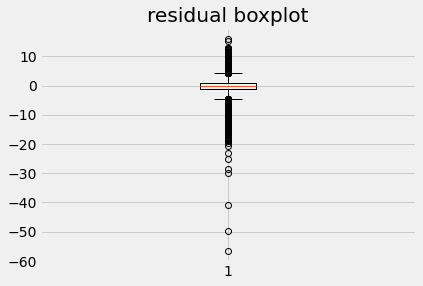

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title('residual boxplot')
ax1.boxplot(df_testWithPreds['PredLessActual'])

#### Run model against holdout data

We have created a holdout set so that we can compare various regression models against the same dataset.  Below, we'll load the data and run inference using the trained model. 

We'll first need to perform the same preprocessing to the holdout set that was done for the train and test set above.

In [27]:
#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab 2\\Data\\Hold_Out_Set.csv"
#load Data into Pandas
df_Holdout = pd.read_csv(file_path)

In [28]:
#since the only NANs are in Holiday and Event, we'll replace those NaNs with 'None' as we did in the train and test set
df_Holdout = df_Holdout.fillna('None')

In [29]:
#check for NaNs again to verify we've taken care of them all
len(df_Holdout) - df_Holdout.count()

CMPLNT_FR_DT          0
Daytime               0
Day_Name              0
Month                 0
Day                   0
Year                  0
Season                0
GeoCell               0
BORO_NM               0
PRCP                  0
SNOW                  0
TMIN                  0
TMAX                  0
Population            0
PC_INCOME             0
Hm_Sls_Price_Range    0
Holiday               0
Event                 0
is_Holiday            0
is_Event              0
count_cmplnt          0
dtype: int64

In [30]:
#grab the candidate variables we want to preprocess by one hot encoding and scaling as we did with the train and test sets
X_holdout = df_Holdout[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event']]
y_holdout = df_Holdout[['count_cmplnt']]

In [31]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season','BORO_NM','Holiday','Event']
columns_no_change = ['is_Holiday','is_Event','Day','Year','GeoCell','PRCP','SNOW','TMIN','TMAX']

df_existing = X_holdout[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(X_holdout[columns_to_encode])

#concatenate processed columns back together for X
X_holdout = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(X_holdout)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
X_holdout = df1

In [32]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_scale = ['PRCP','SNOW','TMIN','TMAX']
#get a list of all columns without the columns to scale above
lstCols = X_holdout.columns.values.tolist()
lstCols.remove('PRCP')
lstCols.remove('SNOW')
lstCols.remove('TMIN')
lstCols.remove('TMAX')
columns_no_change = lstCols

df_existing = X_holdout[columns_no_change]
existing_cols = df_existing.to_numpy()

#separately scale X_holdout
scaled_columns = scaler.transform(X_holdout[columns_to_scale]) #use the fit scaler object from X_train to scale X_holdout

X_holdout_np = np.concatenate([scaled_columns,existing_cols],axis=1)

In [33]:
#convert the numpy array back to a pandas dataframe for X_holdout
df1 = pd.DataFrame(X_holdout_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_holdout = df1

In [34]:
#get our x and y variables set to the appropriate columns
y_holdout = df_Holdout[['count_cmplnt']]
X_holdout = X_holdout[top_features]

In [35]:
#verify our columns in the x are as we expect
X_holdout.columns

Index(['PRCP', 'TMIN', 'TMAX', 'x0_Day', 'x0_Early Morning', 'x0_Evening',
       'x0_Late Night', 'x0_Morning', 'x0_Night', 'x1_Friday', 'x1_Monday',
       'x1_Saturday', 'x1_Sunday', 'x1_Thursday', 'x1_Wednesday', 'x4_BRONX',
       'x4_BROOKLYN', 'x4_MANHATTAN', 'x4_QUEENS', 'Day', 'Year', 'GeoCell'],
      dtype='object')

In [36]:
#run inference against the holdout set
y_pred_holdout = reg.predict(X_holdout)

#### Analyze the model against the Holdout Set

Analyzing the results of the final Random Forest Regression model.

Below, we can see the model metrics MAE, RMSE and the R<sup>2</sup> against the holdout set

In [37]:
from sklearn.metrics import *

#print out the mean absolute error (mae)
print('Mean Absolute Error:', mean_absolute_error(y_holdout,y_pred_holdout),'crimes per period')
print('Root Mean Squared Error:', mean_squared_error(y_holdout,y_pred_holdout, squared=False),'crimes per period')
print('r2:',r2_score(y_holdout,y_pred_holdout))

Mean Absolute Error: 1.7405859086594244 crimes per period
Root Mean Squared Error: 2.715710900010807 crimes per period
r2: 0.7151510083013456


In [38]:
y_holdout.reset_index(drop=True,inplace=True)
df_holdoutWithPreds = pd.concat([X_holdout,y_holdout],axis=1)
df_holdoutWithPreds["prediction"] = reg.predict(X_holdout)
df_holdoutWithPreds['PredLessActual'] = df_holdoutWithPreds['prediction']-df_holdoutWithPreds['count_cmplnt']

Text(0.5, 1.0, 'Actual and Predicted Values against Holdout Set')

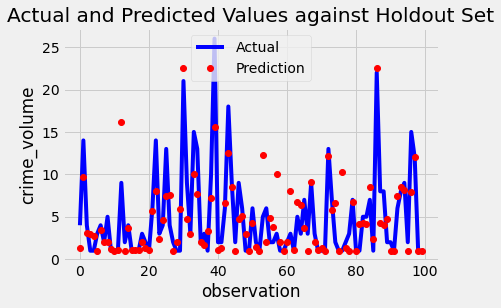

In [39]:
plt.plot(df_holdoutWithPreds['count_cmplnt'].head(100),'b-',label='Actual')
plt.plot(df_holdoutWithPreds['prediction'].head(100),'ro',label='Prediction')
plt.legend()
plt.xlabel('observation'); plt.ylabel('crime_volume'); plt.title('Actual and Predicted Values against Holdout Set')

In [40]:
df_holdoutWithPreds['PredLessActual'].describe()

count    18962.000000
mean        -0.372613
std          2.690098
min        -36.000000
25%         -1.280000
50%          0.000000
75%          0.960000
max         15.710000
Name: PredLessActual, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x26e8a4b51c8>,
 'caps': [<matplotlib.lines.Line2D at 0x26e8a4d4b08>,
 'boxes': [<matplotlib.lines.Line2D at 0x26e8a4d0d88>],
 'medians': [<matplotlib.lines.Line2D at 0x26e8a4dbfc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x26e8a4dba48>],
 'means': []}

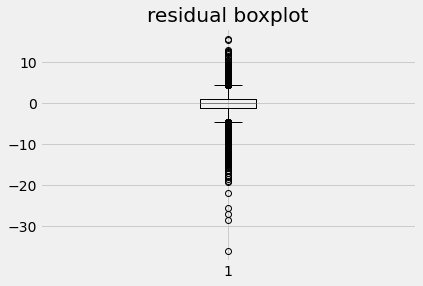

In [41]:
fig1, ax1 = plt.subplots()
ax1.set_title('residual boxplot')
ax1.boxplot(df_holdoutWithPreds['PredLessActual'])

Below are the final metrics for the Random Forest Regression including Root Mean Squared Error and Mean Absolute Error

| Model | Test Set RMSE | Holdout Set RMSE | Test Set MAE | Holdout Set MAE |
| :----------- | ----------- |----------- |----------- |----------- |
| Random Forest Regression | 2.77 | 2.72 | 1.75 | 1.74 |

<a href="#top">Back to Top</a>
<a id="task1Compare"></a>
## Task 1 - Modeling and Evaluation 5 - Comparing 3 Models

<a href="#top">Back to Top</a>
<a id="task1Attributes"></a>
## Task 1 - Modeling and Evaluation 6 - Important Attributes

<a href="#top">Back to Top</a>
<a id="task1Deployment"></a>
## Task 1 - Deployment

<a href="#top">Back to Top</a>
<a id="task2"></a>
# Task 2 - Classification

The classification task is aiming to classify a given crime as being either a Viloent or Non-Violent crime.

<a href="#top">Back to Top</a>
<a id="task2Model1"></a>
## Task 2 - Classification - Model 1 - Random Forest (Approach 1)

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Model2"></a>
## Task 2 - Classification - Model 2 - Logistic Regression

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Model3"></a>
## Task 2 - Classification - Model 3 - Random Forest (Approach 2)

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Compare"></a>
## Task 2 - Modeling and Evaluation 5 - Comparing 3 Models

<a href="#top">Back to Top</a>
<a id="task2Attributes"></a>
## Task 2 -  Modeling and Evaluation 6 - Important Attributes

<a href="#top">Back to Top</a>
<a id="task2Deployment"></a>
## Task 2 - Deployment

<a href="#top">Back to Top</a>
<a id="Exceptional"></a>
# Exceptional Work